## Metis Project 1 - MTA Turnstile data analysis

1. Initialization & Data Cleaning
3. Identify Top 10 Stations
4. Identify best days of week
5. Identify best times of day



---

### 1. Initialization & Data Cleaning

In [10]:
#import libraries
import pandas as pd
import seaborn as sns

import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import calendar
import seaborn as sns


Import data for range April - July 2019

In [11]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

week_nums = [190406, 190413, 190420, 190427, 190504, 190511, 190518, 190525, 190601, 190608, 190615, 190622, 190629, 190706, 190713, 190720, 190727]       
df = get_data(week_nums)

In [12]:
#in case ruin the dataframe
xyz=df.copy()

Tidy columns & filter

In [13]:
#clean column names
df.rename(columns={'C/A': 'c_a', 'UNIT': 'unit', 'SCP': 'scp', 'STATION': 'station', 'LINENAME': 'linename', 'DIVISION': 'division', 'DATE': 'date','TIME': 'time', 'DESC': 'desc', 'ENTRIES': 'entries', df.columns[10]: 'exits'}, inplace=True)

#keep only subway divisions (BMT, IND, IRT)
df = df[(df['division'] == 'BMT') | (df['division'] == 'IND') | (df['division'] == 'IRT')]

#Add formatted timestamp column
df['timestamp'] = pd.to_datetime(df['date'] + " " + df['time'])

#add unique turnstile id
df['unique_turnstile_id'] = df['c_a'] + df['unit'] + ' ' + df['station'] + ' ' + df['scp']

#add day of week column
df['day_of_week'] = df.timestamp.dt.day_name()

#add Hour
df['hour']= list(map(lambda x: int(x.split(':')[0]),df['time'][:]))

df = df.reset_index()

In [14]:
# Get rid of duplicate entries caused by "RECOVER AUD" in desc column, if any
df.sort_values(["c_a", "unit", "scp", "station", "timestamp"], 
                          inplace=True, ascending=False)
df.drop_duplicates(subset=["c_a", "unit", "scp", "station", "timestamp"], inplace=True)

Break out stations previously identified in top 10, but actually having separate locations.

In [15]:
def rename_station(row):
    if row.station == '23 ST' or row.station == '86 ST' or row.station == '125 ST' or row.station == '59 ST' or row.station == '96 ST' or row.station == '14 ST':
        row.station = row.station + ' ' + row.linename
    return row

In [16]:
df = df.apply(rename_station, axis='columns')

Calculate net traffic based on previous turnstile entry.

Additionally, remove the first row of each unique turnstile data. Those rows will have erroneous values since the previous row will be the last of a different turnstile. Therefore, data does not match the same turnstile.

In [17]:
#keep only needed columns
df = df.loc[:,['station', 'entries', 'exits', 'timestamp', 'unique_turnstile_id','hour']]

In [18]:
#calculate actual volumes for each record (record minus previous record)
#absolute value used to handle turnstiles that decrement instead of incrementing counts
df['diff_entries'] = abs(df.entries.diff())
df['diff_exits'] = abs(df.exits.diff())
df['total_traffic'] = df.diff_entries + df.diff_exits

#record index in new column (needed to identify first instance of turnstile data)
df['record_index'] = df.index

In [19]:
#identify first rows of unique turnstile data
df_first_rows = df.groupby('unique_turnstile_id').first()

#index of records of first turnstile rows
list_index = df_first_rows.record_index.values

#drop first rows from main df
df.drop(list_index, inplace=True)

Additional clean up to:
- Remove any rows with net traffic < 1 or more than 14,400 in 4-hour period. We used this number because this would be 1 person through the turnstile per second over the 4-hour period. Anything recorded above that seems unreasonable and erroneous
- Drop `record_index` column previously used to identify first rows of turnstile data. No longer needed

In [20]:
#keep only data with traffic > 0 amd < 14400 (1 person per second)
df = df[(df['total_traffic'] > 0) & (df['total_traffic'] < 14400)]

In [21]:
df["weekday"] = df["timestamp"].dt.day_name()
df.shape

(2832424, 11)

In [22]:
#drop record index column. no longer applies after re-indexing
df.drop(['record_index', 'entries', 'exits'], axis=1, inplace=True)

In [23]:
df = df.reset_index()

---

### 2. Identify Top 10 Stations

In [24]:
df_by_station = df.groupby("station").agg({"total_traffic": 'sum'}).reset_index().sort_values(by="total_traffic", ascending=False)
df_by_station.head(10)

,station,total_traffic
69,34 ST-PENN STA,33322393.0
245,GRD CNTRL-42 ST,29065257.0
67,34 ST-HERALD SQ,25012557.0
349,TIMES SQ-42 ST,20961309.0
19,14 ST-UNION SQ,20533165.0
76,42 ST-PORT AUTH,19969747.0
238,FULTON ST,18241509.0
187,CANAL ST,14546518.0
94,59 ST COLUMBUS,13759907.0
80,47-50 STS ROCK,12041838.0


In [25]:
#save top 10 in list
top10_list = list(df_by_station.station.head(10))

In [26]:
top10_list

['34 ST-PENN STA',
 'GRD CNTRL-42 ST',
 '34 ST-HERALD SQ',
 'TIMES SQ-42 ST',
 '14 ST-UNION SQ',
 '42 ST-PORT AUTH',
 'FULTON ST',
 'CANAL ST',
 '59 ST COLUMBUS',
 '47-50 STS ROCK']

Calculate the proportion of volume held by top 3 & top 10 stations

In [27]:
top_3 = round(df_by_station.iloc[0:3].total_traffic.sum() / df_by_station.total_traffic.sum(), 3) * 100
print(f'Top 3 stations account for {top_3}% of volume')

Top 3 stations account for 8.6% of volume


In [28]:
top_10 = round((df_by_station.iloc[0:10].total_traffic.sum() / df_by_station.total_traffic.sum()) * 100, 1)
print(f'Top 10 stations account for {top_10}% of volume')

Top 10 stations account for 20.5% of volume


---

### 3. Identify best days of week for Top 10

In [29]:
#add day of week column
df["weekday"] = df["timestamp"].dt.day_name()

In [30]:
#groupby station and weekday
df_by_station = df.groupby(["station", "weekday"]).agg({'total_traffic': 'sum'}).reset_index().sort_values(by="total_traffic", ascending=False)
df_by_station

,station,weekday,total_traffic
489,34 ST-PENN STA,Wednesday,5738987.0
488,34 ST-PENN STA,Tuesday,5698597.0
487,34 ST-PENN STA,Thursday,5639291.0
483,34 ST-PENN STA,Friday,5389296.0
484,34 ST-PENN STA,Monday,5317194.0
...,...,...,...
2195,ORCHARD BEACH,Thursday,1396.0
2197,ORCHARD BEACH,Wednesday,282.0
2191,ORCHARD BEACH,Friday,232.0
2192,ORCHARD BEACH,Monday,197.0


Filter rows for top 10 and identify best days

In [31]:
df_top10_byday = df_by_station.loc[df_by_station['station'].isin(top10_list)]
#df_top10_byday(10)

Create pivot to stage for heatmap

In [32]:
top10_pivot = df_top10_byday.pivot("station", "weekday", "total_traffic")
week_list = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
top10_pivot = top10_pivot[week_list]

#order by top 10 list order
for i in range(10):
    top10_pivot.loc[top10_list[i], 'order'] = i

top10_pivot = top10_pivot.sort_values(by='order')
top10_pivot.drop('order', axis=1, inplace=True)
top10_pivot

weekday,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
station,,,,,,,
34 ST-PENN STA,2544634.0,5317194.0,5698597.0,5738987.0,5639291.0,5389296.0,2994394.0
GRD CNTRL-42 ST,1570693.0,4909459.0,5314691.0,5309667.0,5198165.0,4747073.0,2015509.0
34 ST-HERALD SQ,1953345.0,3886188.0,4162325.0,4270606.0,4148644.0,4099599.0,2491850.0
TIMES SQ-42 ST,1710574.0,3116497.0,3484264.0,3584389.0,3462651.0,3359119.0,2243815.0
14 ST-UNION SQ,1684550.0,3096709.0,3384861.0,3485136.0,3307983.0,3324124.0,2249802.0
42 ST-PORT AUTH,1757649.0,3056266.0,3257233.0,3286585.0,3249179.0,3213678.0,2149157.0
FULTON ST,980915.0,3037897.0,3318441.0,3304913.0,3254168.0,3034866.0,1310309.0
CANAL ST,1226533.0,2200114.0,2360620.0,2398904.0,2388111.0,2349851.0,1622385.0
59 ST COLUMBUS,1152338.0,2115085.0,2287441.0,2358355.0,2274668.0,2116554.0,1455466.0


Calculate % volume for each day

In [33]:
for i in range(7):
    percent_sum = int(round(top10_pivot[week_list[i]].sum() / top10_pivot.sum().sum(), 3) * 100)
    print(f'{week_list[i]}: {percent_sum}%')

Sunday: 7%
Monday: 15%
Tuesday: 17%
Wednesday: 17%
Thursday: 16%
Friday: 16%
Saturday: 9%


Heatmap of volume by station by day of week

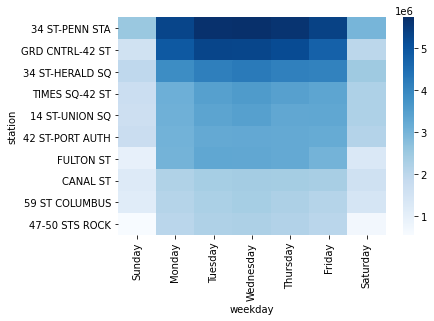

In [34]:
ax = sns.heatmap(top10_pivot, cmap="Blues")

Heatmap normalized across rows to be able to see the differences in color. Comparisons should be done across rows for data in each station

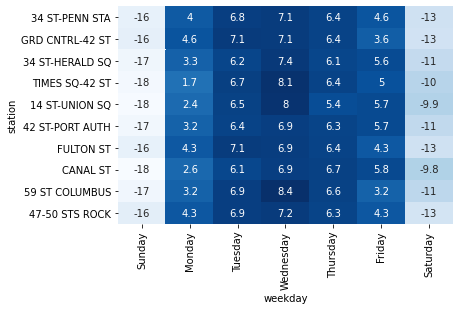

In [35]:
# substract mean
df_norm_row=top10_pivot.sub(top10_pivot.mean(axis=1), axis=0)
# divide by standard dev
df_norm_row=df_norm_row.div(top10_pivot.std(axis=1), axis=0)
df_norm_row=df_norm_row.mul(10, axis=0)

ax = sns.heatmap(df_norm_row, cmap="Blues", annot=True, cbar=False)

---

### 4. Identify best times of day

In [37]:
df.head()
df_by_hour=df

#Calculate Hourly traffic (Average)
df_by_hour['Hourly_traffic']=df_by_hour['total_traffic']/4

#plit Column containing lists into different rows
df_by_hour['Hour']= list(map(lambda x : [x-1, x-2, x-3, x-4],df_by_hour['hour']))
df_by_hour_update = pd.DataFrame({
      col:np.repeat(df_by_hour[col].values, df_by_hour['Hour'].str.len())
      for col in df_by_hour.columns.drop('Hour')}
    ).assign(**{'Hour':np.concatenate(df_by_hour['Hour'].values)})[df_by_hour.columns]


def check_neg_hour(x):
    if x<0: 
        x+=24
    else:
        pass
    return x

df_by_hour_update['Hour']=list(map(check_neg_hour, df_by_hour_update['Hour']))

In [39]:
# Add Column for Month
df_by_hour_update["Month"]=pd.DatetimeIndex(df_by_hour_update["timestamp"]).month

df_by_hour_update["Month"]=list(map(lambda x: calendar.month_name[x],df_by_hour_update["Month"]))


In [40]:
df_by_hour_update

dic_hour={"0-4":[0,1,2,3],"04-08":[4,5,6,7],
              "08-12":[8,9,10,11],"12-16":[12,13,14,15],
             "16-20":[16,17,18,19],"20-24":[20,21,22,23]}
def fillin_hour_range(x):
    for i, cata in dic_hour.items():
        if x in cata:
            x=i
    return x
        

df_by_hour_update['Hour']= list(map(fillin_hour_range,df_by_hour_update['Hour']))
df_by_hour_update.head()

,index,station,timestamp,unique_turnstile_id,hour,diff_entries,diff_exits,total_traffic,weekday,Hourly_traffic,Hour,Month
0,3233363,EASTCHSTER/DYRE,2019-07-26 17:00:00,R730R431 EASTCHSTER/DYRE 00-00-04,17,38.0,51.0,89.0,Friday,22.25,16-20,July
1,3233363,EASTCHSTER/DYRE,2019-07-26 17:00:00,R730R431 EASTCHSTER/DYRE 00-00-04,17,38.0,51.0,89.0,Friday,22.25,12-16,July
2,3233363,EASTCHSTER/DYRE,2019-07-26 17:00:00,R730R431 EASTCHSTER/DYRE 00-00-04,17,38.0,51.0,89.0,Friday,22.25,12-16,July
3,3233363,EASTCHSTER/DYRE,2019-07-26 17:00:00,R730R431 EASTCHSTER/DYRE 00-00-04,17,38.0,51.0,89.0,Friday,22.25,12-16,July
4,3233362,EASTCHSTER/DYRE,2019-07-26 13:00:00,R730R431 EASTCHSTER/DYRE 00-00-04,13,95.0,52.0,147.0,Friday,36.75,12-16,July
...,...,...,...,...,...,...,...,...,...,...,...,...
11329691,1,59 ST NQR456W,2019-03-30 04:00:00,A002R051 59 ST 02-00-00,4,23.0,46.0,69.0,Saturday,17.25,0-4,March
11329692,0,59 ST NQR456W,2019-03-30 00:00:00,A002R051 59 ST 02-00-00,0,20.0,8.0,28.0,Saturday,7.00,20-24,March
11329693,0,59 ST NQR456W,2019-03-30 00:00:00,A002R051 59 ST 02-00-00,0,20.0,8.0,28.0,Saturday,7.00,20-24,March
11329694,0,59 ST NQR456W,2019-03-30 00:00:00,A002R051 59 ST 02-00-00,0,20.0,8.0,28.0,Saturday,7.00,20-24,March


##### Plot for 34 ST-PENN STA (Top 1)

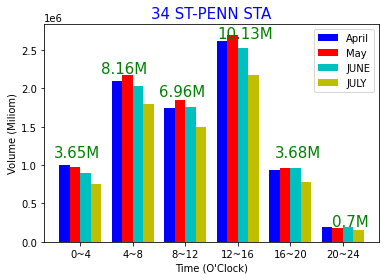

In [51]:
#34 ST-PENN STA
penn_34=df_by_hour_update[df_by_hour_update.station=="34 ST-PENN STA"]

#sorted(penn_34['hour'].value_counts())
#penn_34['hour'].value_counts()
plot_penn_34=penn_34.groupby(["station","Month","Hour"]).agg({'Hourly_traffic':'sum'}).reset_index()
#df_penn_34.head(10)
#plot_penn_34

apr=plot_penn_34[plot_penn_34.Month=='April']
may=plot_penn_34[plot_penn_34.Month=='May']
jun=plot_penn_34[plot_penn_34.Month=='June']
july=plot_penn_34[plot_penn_34.Month=='July']


xticks = np.arange(6)+ (6 / 2.) * 0.2
x_jun = np.arange(len(jun.Hour))
x_july=np.arange(len(july.Hour))
x_apr=np.arange(len(apr.Hour))
x_may=np.arange(len(may.Hour))

plt.bar(x_apr-0.3, apr.Hourly_traffic, color = 'b', width = 0.2);
plt.bar(x_may-0.1, may.Hourly_traffic,color = 'r', width = 0.2);
plt.bar(x_jun+0.1, jun.Hourly_traffic,color = 'c', width = 0.2);
plt.bar(x_july+0.3, july.Hourly_traffic,color = 'y', width = 0.2);
#plt.xlim([0 - 0.1, max(xticks) + (6 * 0.5)])
plt.title('34 ST-PENN STA',family='sans-serif',fontsize = 15,color='b');
plt.xlabel('Time (O\'Clock)')
plt.ylabel('Volume (Miliom)')
#plt.linewidth(5)
plt.xticks(np.arange(6),('0~4', '4~8', '8~12', '12~16', '16~20', '20~24'))
#plt.yticks(np.linspace(0, 700000, 6))
plt.text(-0.5, 1100000, '3.65M',
        color='green', fontsize=15)

plt.text(0.4, 2200000, '8.16M',
        color='green', fontsize=15)

plt.text(1.5, 1900000, '6.96M',
        color='green', fontsize=15)


plt.text(2.6, 2650000, '10.13M',
        color='green', fontsize=15)


plt.text(3.7, 1100000, '3.68M',
        color='green', fontsize=15)

plt.text(4.8, 200000, '0.7M',
        color='green', fontsize=15)

#print(penn_34.groupby(["Hour"])["Hourly_traffic"].sum())
plt.legend(['April','May','JUNE','JULY'])
plt.show();

##### Plot for GRD CNTRL-42 ST (Top 2)

In [ ]:
### GRD_CNTRL=df_by_hour_update[df_by_hour_update.station=="GRD CNTRL-42 ST"]
plot_GRD_CNTRL=GRD_CNTRL.groupby(["station","Month","Hour"]).agg({'Hourly_traffic':'sum'}).reset_index()

plot_GRD_CNTRL



apr=plot_GRD_CNTRL[plot_GRD_CNTRL.Month=='April']
may=plot_GRD_CNTRL[plot_GRD_CNTRL.Month=='May']
jun=plot_GRD_CNTRL[plot_GRD_CNTRL.Month=='June']
july=plot_GRD_CNTRL[plot_GRD_CNTRL.Month=='July']


xticks = np.arange(6)+ (6 / 2.) * 0.2
x_jun = np.arange(len(jun.Hour))
x_july=np.arange(len(july.Hour))
x_apr=np.arange(len(apr.Hour))
x_may=np.arange(len(may.Hour))

plt.bar(x_apr-0.3, apr.Hourly_traffic, color = 'b', width = 0.2);
plt.bar(x_may-0.1, may.Hourly_traffic,color = 'r', width = 0.2);
plt.bar(x_jun+0.1, jun.Hourly_traffic,color = 'c', width = 0.2);
plt.bar(x_july+0.3, july.Hourly_traffic,color = 'y', width = 0.2);
#plt.xlim([0 - 0.1, max(xticks) + (6 * 0.5)])
plt.title('GRD CNTRL-42 ST',family='sans-serif',fontsize = 15,color='b');
plt.xlabel('Time (O\'Clock)')
plt.ylabel('Volume (Miliom)')


plt.text(-0.5, 1200000, '3.32M',
        color='green', fontsize=15)

plt.text(0.4, 2000000, '7.62M',
        color='green', fontsize=15)

plt.text(1.5, 1750000, '6.17M',
        color='green', fontsize=15)

plt.text(2.6, 2350000, '8.94M',
        color='green', fontsize=15)

plt.text(3.7, 950000, '3.09M',
        color='green', fontsize=15)

plt.text(4.8, 175000, '0.47M',
        color='green', fontsize=15)

print(GRD_CNTRL.groupby(["Hour"])["Hourly_traffic"].sum())



#plt.linewidth(5)
plt.xticks(np.arange(6),('0~4', '4~8', '8~12', '12~16', '16~20', '20~24'))
#plt.yticks(np.linspace(0, 700000, 6))
plt.legend(['April','May','JUNE','JULY'])
plt.show();


##### Plot for 34 ST-HERALD SQ (Top 3)

Hour
0-4      1645874.75
04-08    5920634.50
08-12    5297996.50
12-16    8592700.25
16-20    3106555.25
20-24     448795.75
Name: Hourly_traffic, dtype: float64


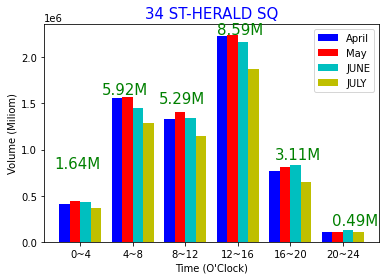

In [44]:
HERALD_34=df_by_hour_update[df_by_hour_update.station=="34 ST-HERALD SQ"]
plot_HERALD_34=HERALD_34.groupby(["station","Month","Hour"]).agg({'Hourly_traffic':'sum'}).reset_index()

plot_HERALD_34


apr=plot_HERALD_34[plot_HERALD_34.Month=='April']
may=plot_HERALD_34[plot_HERALD_34.Month=='May']
jun=plot_HERALD_34[plot_HERALD_34.Month=='June']
july=plot_HERALD_34[plot_HERALD_34.Month=='July']


xticks = np.arange(6)+ (6 / 2.) * 0.2
x_jun = np.arange(len(jun.Hour))
x_july=np.arange(len(july.Hour))
x_apr=np.arange(len(apr.Hour))
x_may=np.arange(len(may.Hour))

plt.bar(x_apr-0.3, apr.Hourly_traffic, color = 'b', width = 0.2);
plt.bar(x_may-0.1, may.Hourly_traffic,color = 'r', width = 0.2);
plt.bar(x_jun+0.1, jun.Hourly_traffic,color = 'c', width = 0.2);
plt.bar(x_july+0.3, july.Hourly_traffic,color = 'y', width = 0.2);
#plt.xlim([0 - 0.1, max(xticks) + (6 * 0.5)])
plt.title('34 ST-HERALD SQ',family='sans-serif',fontsize = 15,color='b');
plt.xlabel('Time (O\'Clock)')
plt.ylabel('Volume (Miliom)')

plt.text(-0.5, 800000, '1.64M',
        color='green', fontsize=15)

plt.text(0.4, 1600000, '5.92M',
        color='green', fontsize=15)

plt.text(1.5, 1500000, '5.29M',
        color='green', fontsize=15)

plt.text(2.6, 2250000, '8.59M',
        color='green', fontsize=15)

plt.text(3.7, 900000, '3.11M',
        color='green', fontsize=15)

plt.text(4.8, 175000, '0.49M',
        color='green', fontsize=15)

print(HERALD_34.groupby(["Hour"])["Hourly_traffic"].sum())



#plt.linewidth(5)
plt.xticks(np.arange(6),('0~4', '4~8', '8~12', '12~16', '16~20', '20~24'))
#plt.yticks(np.linspace(0, 700000, 6))
plt.legend(['April','May','JUNE','JULY'])
plt.show();


##### Plot for TIMES SQ-42 ST (Top 4)

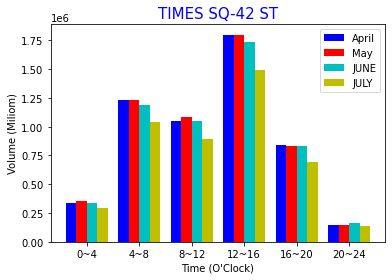

In [46]:
TIMES_SQ=df_by_hour_update[df_by_hour_update.station=="TIMES SQ-42 ST"]
plot_TIMES_SQ=TIMES_SQ.groupby(["station","Month","Hour"]).agg({'Hourly_traffic':'sum'}).reset_index()

plot_TIMES_SQ


apr=plot_TIMES_SQ[plot_TIMES_SQ.Month=='April']
may=plot_TIMES_SQ[plot_TIMES_SQ.Month=='May']
jun=plot_TIMES_SQ[plot_TIMES_SQ.Month=='June']
july=plot_TIMES_SQ[plot_TIMES_SQ.Month=='July']


xticks = np.arange(6)+ (6 / 2.) * 0.2
x_jun = np.arange(len(jun.Hour))
x_july=np.arange(len(july.Hour))
x_apr=np.arange(len(apr.Hour))
x_may=np.arange(len(may.Hour))

plt.bar(x_apr-0.3, apr.Hourly_traffic, color = 'b', width = 0.2);
plt.bar(x_may-0.1, may.Hourly_traffic,color = 'r', width = 0.2);
plt.bar(x_jun+0.1, jun.Hourly_traffic,color = 'c', width = 0.2);
plt.bar(x_july+0.3, july.Hourly_traffic,color = 'y', width = 0.2);
#plt.xlim([0 - 0.1, max(xticks) + (6 * 0.5)])
plt.title('TIMES SQ-42 ST',family='sans-serif',fontsize = 15,color='b');
plt.xlabel('Time (O\'Clock)')
plt.ylabel('Volume (Miliom)')
#plt.linewidth(5)
plt.xticks(np.arange(6),('0~4', '4~8', '8~12', '12~16', '16~20', '20~24'))
#plt.yticks(np.linspace(0, 700000, 6))
plt.legend(['April','May','JUNE','JULY'])
plt.show();

##### Plot for 14 ST-UNION SQ (Top 5)

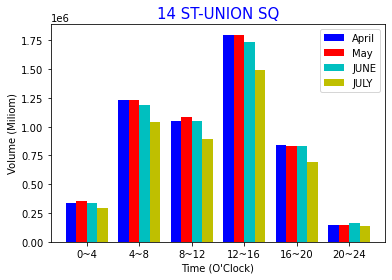

In [48]:
UNION_SQ_14=df_by_hour_update[df_by_hour_update.station=="14 ST-UNION SQ"]
plot_UNION_SQ_14=TIMES_SQ.groupby(["station","Month","Hour"]).agg({'Hourly_traffic':'sum'}).reset_index()

plot_UNION_SQ_14


apr=plot_UNION_SQ_14[plot_UNION_SQ_14.Month=='April']
may=plot_UNION_SQ_14[plot_UNION_SQ_14.Month=='May']
jun=plot_UNION_SQ_14[plot_UNION_SQ_14.Month=='June']
july=plot_UNION_SQ_14[plot_UNION_SQ_14.Month=='July']


xticks = np.arange(6)+ (6 / 2.) * 0.2
x_jun = np.arange(len(jun.Hour))
x_july=np.arange(len(july.Hour))
x_apr=np.arange(len(apr.Hour))
x_may=np.arange(len(may.Hour))

plt.bar(x_apr-0.3, apr.Hourly_traffic, color = 'b', width = 0.2);
plt.bar(x_may-0.1, may.Hourly_traffic,color = 'r', width = 0.2);
plt.bar(x_jun+0.1, jun.Hourly_traffic,color = 'c', width = 0.2);
plt.bar(x_july+0.3, july.Hourly_traffic,color = 'y', width = 0.2);
#plt.xlim([0 - 0.1, max(xticks) + (6 * 0.5)])
plt.title('14 ST-UNION SQ',family='sans-serif',fontsize = 15,color='b');
plt.xlabel('Time (O\'Clock)')
plt.ylabel('Volume (Miliom)')
#plt.linewidth(5)
plt.xticks(np.arange(6),('0~4', '4~8', '8~12', '12~16', '16~20', '20~24'))
#plt.yticks(np.linspace(0, 700000, 6))
plt.legend(['April','May','JUNE','JULY'])
plt.show();

### 5.  Identify best times of each day of week

In [49]:
df_week=df_by_hour_update
calendar.day_name[df_week["timestamp"][1].weekday()]
df_week["Week"]= list(map(lambda x: calendar.day_name[x.weekday()], 
                          df_week["timestamp"]))


<AxesSubplot:xlabel='Week', ylabel='Hour'>

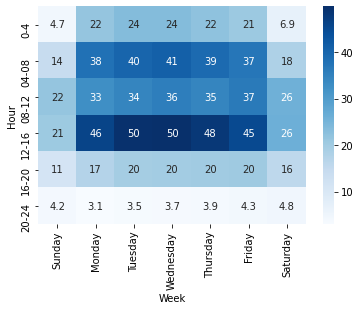

In [50]:
a=df_week.groupby(["Week","Hour"]).agg({'Hourly_traffic':'sum'}).reset_index()
a['Hourly_traffic']=a['Hourly_traffic']/1000000
pv=a.pivot('Hour','Week','Hourly_traffic')

pv = pv[['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']]
sns.heatmap(pv, cmap="Blues", annot=True)
